In [13]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sys
import torch
torch.set_default_tensor_type(torch.FloatTensor) # set the default to float32
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import time
from scipy.stats import multivariate_normal

from RCT_experiment import *
from Bayes_linear_regression import *
from plotting_functions import *
from MCMC_Bayesian_update import *
from utils import *


### 1. Simulating the data

In [14]:
rng = np.random.RandomState(42)
show_plots = True

n_host_and_mirror = 1000
X0 = np.random.randint(0, 2, size=n_host_and_mirror)
X1 = np.random.normal(size=n_host_and_mirror)
x_distributions = {0: X0, 1: X1}

p_assigned_to_host = lambda X_1, X_2, T, eps: sigmoid(1 + X_1 - X_2 + T + eps)
p_assigned_to_cand2 = lambda X_1, X_2, T, eps: sigmoid(1 - 3*X_1 + eps)
X_rct, T_rct = generate_rct(n_host_and_mirror, x_distributions)

data_host, data_mirror = generate_host_and_mirror(X_rct, T_rct, p_assigned_to_cand2)
design_data_host = generate_design_matrix(data_host, power_x=1, power_x_t=1)
design_data_mirror = generate_design_matrix(data_mirror, power_x=1, power_x_t=1)

n_pre_cand2 = 500
pre_X_cand2, pre_T_cand2 = generate_rct(n_pre_cand2, x_distributions)
data_cand2 = generate_host2(pre_X_cand2, pre_T_cand2, p_assigned_to_cand2, n_cand2=100)
design_data_cand2 = generate_design_matrix(data_cand2, power_x=1, power_x_t=1)

outcome_function = lambda X, T, eps: 1 + 0 * X[:,0] + 1 * X[:,1] + 1 * T - 0* X[:,1]*T + eps 
std_true_y = 0.0 # Standard deviation for the true Y
design_data_host = add_outcome(design_data_host, outcome_function, std_true_y)
design_data_mirror = add_outcome(design_data_mirror, outcome_function, std_true_y)
design_data_cand2 = add_outcome(design_data_cand2, outcome_function, std_true_y)

### 2. Simulating from prior and plotting
Note: I don't think this is the right way to compare if our estimates are getting better but it will do for now

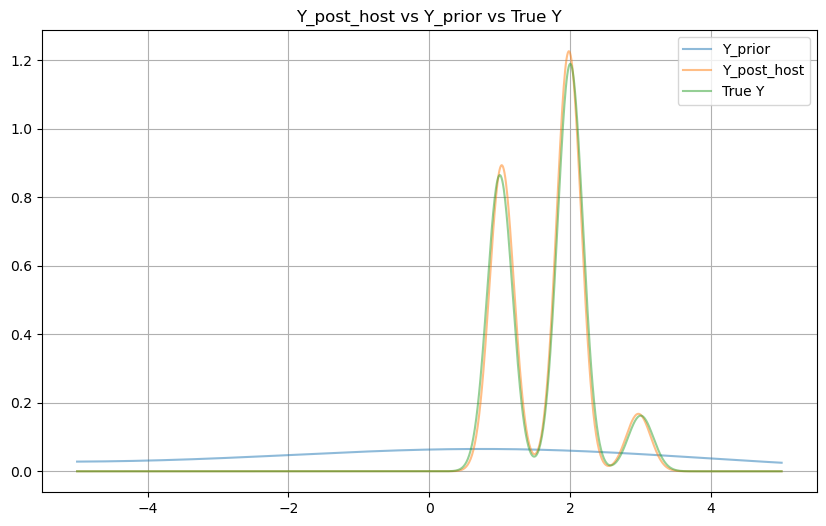

In [15]:
# Initialize prior parameters
# post_mean = np.array([-10, 0.5, 2, -10, 0, -4])
# a = beta_post_host_vec
post_mean = np.array([1, 0.5, 2, -12, 0, -6])
beta_0, sigma_0_sq = post_mean, 1
prior_hyperparameters = {'beta_0': beta_0, 'sigma_0_sq': sigma_0_sq}
bayes_reg = BayesianLinearRegression(prior_hyperparameters)

### Bayesian update through host dataset
X_host, Y_host= design_data_host.drop(columns=['Y']), design_data_host['Y']
post_host_parameters = bayes_reg.fit(X_host, Y_host)

# Generate Y_prior
sigma_prior = 1  # Standard deviation for Y_prior
Y_prior = np.dot(X_host, beta_0) + np.random.normal(0, sigma_prior, len(X_host))

# Generate Y_post_host
beta_post_host_vec = post_host_parameters['posterior_mean'].flatten()  # Extract posterior mean
cov_matrix_post_host = post_host_parameters['posterior_cov_matrix']
Y_post_host = np.dot(X_host, beta_post_host_vec) + np.random.normal(0, 0.01, len(X_host))  # Assuming standard deviation for Y_post_host is 1

plot_densities(Y_prior, Y_post_host, design_data_host['Y'], 
                names = ['Y_prior', 'Y_post_host', 'True Y'], 
                title = 'Y_post_host vs Y_prior vs True Y')


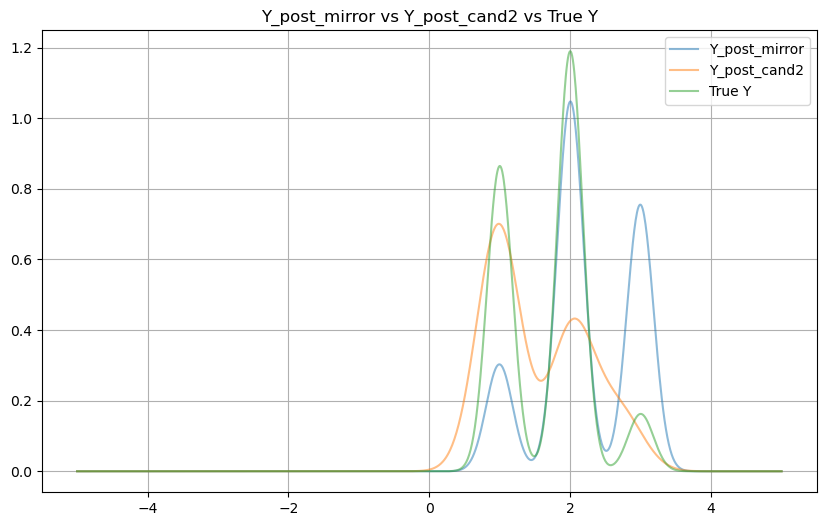

In [16]:
### Bayesian update through candidate datasets
sigma_cand = 1
prior_hyperparameters_cand = {'beta_0': beta_post_host_vec, 'sigma_0_sq': sigma_cand}

## With candidate = mirror dataset
bayes_reg_mirror = BayesianLinearRegression(prior_hyperparameters_cand)
X_mirror, Y_mirror = design_data_mirror.drop(columns=['Y']), design_data_mirror['Y']
post_mirror_parameters = bayes_reg_mirror.fit(X_mirror, Y_mirror)

# Generate Y_post_mirror
post_mirror_mean = post_mirror_parameters['posterior_mean'].flatten()  # Extract posterior mean
Y_post_mirror = np.dot(X_mirror, post_mirror_mean) + np.random.normal(0, 0.01, len(X_mirror))  # Assuming standard deviation for Y_post_host is 1

## With candidate = cand2 dataset
bayes_reg_cand2 = BayesianLinearRegression(prior_hyperparameters_cand)
X_cand2, Y_cand2 = design_data_cand2.drop(columns=['Y']), design_data_cand2['Y']
post_cand2_parameters = bayes_reg_cand2.fit(X_cand2, Y_cand2)

# Generate Y_post_cand2
post_cand2_mean = post_cand2_parameters['posterior_mean'].flatten()  # Extract posterior mean
Y_post_cand2 = np.dot(X_cand2, post_cand2_mean) + np.random.normal(0, 0.01, len(X_cand2))  # Assuming standard deviation for Y_post_host is 1

plot_densities(Y_post_mirror, Y_post_cand2, design_data_host['Y'],
                names = ['Y_post_mirror', 'Y_post_cand2', 'True Y'], 
                title = 'Y_post_mirror vs Y_post_cand2 vs True Y')


In [25]:
#Number of samples used to estimate outer expectation
n_samples_for_expectation = 200
m_samples_for_expectation = int(np.ceil(np.sqrt(n_samples_for_expectation)))
# Incorporating sqrt constraint into MCMC samples
n_mcmc = (n_samples_for_expectation * (m_samples_for_expectation+1)) 

warmup_steps = 500
max_tree_depth = 7
sigma_rand_error = 1

X_torch = torch.tensor(X_host.values)
Y_torch = torch.tensor(Y_host.values)

## Bayesian update using the host dataset
mcmc_host = MCMC_Bayesian_update(X_torch =X_torch, Y_torch = Y_torch, model =model_normal,
            mu_0= beta_0, sigma_prior = sigma_prior, sigma_rand_error = sigma_rand_error,
            sigma_rand_error_fixed = True,n_mcmc = n_mcmc, warmup_steps = warmup_steps, max_tree_depth=max_tree_depth)
mcmc_host.summary()

beta_post_host = pd.DataFrame(mcmc_host.get_samples())

#Shuffling to remove any dependence between adjacent samples
beta_post_host = beta_post_host.sample(frac = 1)

beta_post_host.head()
# We delete the column with the std
beta_post_host_without_std = beta_post_host.iloc[:, :-1] 

Sample: 100%|██████████| 3700/3700 [00:24, 149.60it/s, step size=4.32e-01, acc. prob=0.912]

Inference ran for 0.41 minutes

                mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta_0      1.08      0.08      1.08      0.96      1.21   1770.92      1.00
    beta_1      0.92      0.17      0.92      0.63      1.20   1864.56      1.00
    beta_2      0.04      0.07      0.04     -0.07      0.15   1984.94      1.00
    beta_3      0.85      0.11      0.85      0.67      1.01   1734.05      1.00
    beta_4      0.15      0.25      0.15     -0.26      0.56   2028.30      1.00
    beta_5     -0.07      0.10     -0.07     -0.22      0.11   2135.53      1.00

Number of divergences: 0


# We should have that the mean of beta_post_host is beta_post_host_vec here

In [18]:
X_host.shape

(423, 6)

In [19]:
[1, 0, 1, 1, 0, 0]

[1, 0, 1, 1, 0, 0]

In [27]:
beta_post_host_vec

array([ 1.02800829,  0.97878814,  0.01461745,  0.94837316,  0.01021653,
       -0.03146422])

In [26]:
beta_post_host.describe()

,beta_0,beta_1,beta_2,beta_3,beta_4,beta_5
count,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000
mean,1.082189,0.916019,0.037603,0.847310,0.150183,-0.066641
std,0.076649,0.172823,0.068189,0.106219,0.251911,0.098674
min,0.805779,0.370724,-0.178421,0.443256,-0.719544,-0.447996
25%,1.029764,0.798447,-0.007273,0.775380,-0.018284,-0.133531
50%,1.081248,0.915643,0.038166,0.846936,0.153994,-0.067224
75%,1.133591,1.032547,0.082426,0.919309,0.318046,0.000588
max,1.330519,1.500187,0.266187,1.229296,0.968728,0.296164


### 3. Calculating EIG

For the mirror dataset

First, we calculate EIG using samples by getting the model predictions and putting them in the correct form

In [23]:
X_mirror_arr = X_mirror.values
Y_pred_mirror = predict_with_all_sampled_linear(beta_post_host, X_mirror_arr)

pred_list_mirror = predictions_in_EIG_obs_form(Y_pred_mirror,n_samples_for_expectation,m_samples_for_expectation)

In [24]:
compute_EIG_obs_from_samples(pred_list_mirror, sigma_rand_error)

KeyboardInterrupt: 

Now to calculate for the causal

In [ ]:
from functools import partial
from MCMC_Bayesian_update import retun_causal_samp_func_linear


In [ ]:
sample_func = retun_causal_samp_func_linear(X=X_torch,Y=Y_torch,causal_param_first_index=3,mu_0=beta_0,sigma_prior = sigma_prior,
                                            sigma_rand_error = sigma_rand_error,sigma_rand_error_fixed = True,warmup_steps = warmup_steps, max_tree_depth=max_tree_depth)
pred_func = lambda beta: beta @ (X_mirror).T

In [ ]:
pred_in_causal_form = predictions_in_EIG_causal_form(pred_func, theta_samples=beta_post_host.values[:10], theta_sampling_function=sample_func, n_non_causal_expectation=100, causal_param_first_index=3)

/Users/jake/Python/causal_prospective_merge/MCMC_Bayesian_update.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_new = torch.tensor(Y_new)
/Users/jake/Python/causal_prospective_merge/MCMC_Bayesian_update.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_new = torch.tensor(X_new)
Sample: 100%|██████████| 120/120 [00:00, 348.31it/s, step size=1.41e+00, acc. prob=0.015]
/Users/jake/Python/causal_prospective_merge/MCMC_Bayesian_update.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_new = torch.tensor(Y_new)
/Users/jake/Pyth

Inference ran for 0.01 minutes


Sample: 100%|██████████| 120/120 [00:00, 212.94it/s, step size=1.53e+00, acc. prob=0.107]
/Users/jake/Python/causal_prospective_merge/MCMC_Bayesian_update.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_new = torch.tensor(Y_new)
/Users/jake/Python/causal_prospective_merge/MCMC_Bayesian_update.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_new = torch.tensor(X_new)


Inference ran for 0.01 minutes


Sample: 100%|██████████| 120/120 [00:00, 319.71it/s, step size=4.06e+00, acc. prob=0.000]
/Users/jake/Python/causal_prospective_merge/MCMC_Bayesian_update.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_new = torch.tensor(Y_new)
/Users/jake/Python/causal_prospective_merge/MCMC_Bayesian_update.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_new = torch.tensor(X_new)


Inference ran for 0.01 minutes


Sample: 100%|██████████| 120/120 [00:00, 233.37it/s, step size=4.10e-01, acc. prob=0.417]
/Users/jake/Python/causal_prospective_merge/MCMC_Bayesian_update.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_new = torch.tensor(Y_new)
/Users/jake/Python/causal_prospective_merge/MCMC_Bayesian_update.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_new = torch.tensor(X_new)


Inference ran for 0.01 minutes


Sample: 100%|██████████| 120/120 [00:00, 278.83it/s, step size=2.17e+00, acc. prob=0.015]
/Users/jake/Python/causal_prospective_merge/MCMC_Bayesian_update.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_new = torch.tensor(Y_new)
/Users/jake/Python/causal_prospective_merge/MCMC_Bayesian_update.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_new = torch.tensor(X_new)


Inference ran for 0.01 minutes


Sample: 100%|██████████| 120/120 [00:00, 457.30it/s, step size=1.84e+00, acc. prob=0.129]
/Users/jake/Python/causal_prospective_merge/MCMC_Bayesian_update.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_new = torch.tensor(Y_new)
/Users/jake/Python/causal_prospective_merge/MCMC_Bayesian_update.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_new = torch.tensor(X_new)


Inference ran for 0.0 minutes


Sample: 100%|██████████| 120/120 [00:00, 174.78it/s, step size=4.40e-01, acc. prob=0.738]
/Users/jake/Python/causal_prospective_merge/MCMC_Bayesian_update.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_new = torch.tensor(Y_new)
/Users/jake/Python/causal_prospective_merge/MCMC_Bayesian_update.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_new = torch.tensor(X_new)


Inference ran for 0.01 minutes


Sample: 100%|██████████| 120/120 [00:00, 190.21it/s, step size=6.35e-01, acc. prob=0.850]
/Users/jake/Python/causal_prospective_merge/MCMC_Bayesian_update.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_new = torch.tensor(Y_new)
/Users/jake/Python/causal_prospective_merge/MCMC_Bayesian_update.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_new = torch.tensor(X_new)


Inference ran for 0.01 minutes


Sample: 100%|██████████| 120/120 [00:00, 315.70it/s, step size=3.37e+00, acc. prob=0.000]
/Users/jake/Python/causal_prospective_merge/MCMC_Bayesian_update.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_new = torch.tensor(Y_new)
/Users/jake/Python/causal_prospective_merge/MCMC_Bayesian_update.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_new = torch.tensor(X_new)


Inference ran for 0.01 minutes


Sample: 100%|██████████| 120/120 [00:00, 322.03it/s, step size=8.59e-01, acc. prob=0.174]

Inference ran for 0.01 minutes


In [ ]:
compute_EIG_causal_from_samples(pred_list_mirror,pred_in_causal_form, sigma_rand_error)

-46.81859566232333

Now, trying to calculate in closed form

In [ ]:
compute_EIG_obs_closed_form(X_mirror_arr,cov_matrix_post_host,sigma_rand_error)

19.7293233218143

In [ ]:
compute_EIG_causal_closed_form(X_mirror_arr, cov_matrix_post_host,sigma_rand_error, 3)

9.483024967657888

For the cand2 dataset

In [ ]:
X_cand2_arr = X_cand2.values
Y_pred_cand2 = predict_with_all_sampled_linear(beta_post_host, X_cand2_arr)

pred_list_cand2 = samples_in_EIG_form(Y_pred_cand2, n_samples_for_expectation, m_samples_for_expectation)

In [ ]:
compute_EIG_obs_from_samples(pred_list_cand2, sigma_rand_error)

24.915662640204552

Now, trying to calculate in closed form

In [ ]:
compute_EIG_obs_closed_form(X_cand2_arr, cov_matrix_post_host, sigma_rand_error)

12.038579085422892

In [ ]:
compute_EIG_causal_closed_form(X_cand2_arr, cov_matrix_post_host, sigma_rand_error, 3)

5.662853036225751